# series oof df
series_idごとのoof scoreをチェック
errorがどういう波形に対して発生しているかを確認する

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
import sys
sys.path.append("/kaggle/src/dss_utils")

from dss_metrics import score


# Config

In [3]:
output_dir = os.path.join("/kaggle", "working", "_oof")
# exp_name = "debug"
exp_name = "exp025_alldata_skf_lstmenchead_epoch30"


# fn

In [11]:
# postprocess_fn
# series_idでgroupbyして、class_predに対して対象の列のデータから前のN個の列までのデータの平均をとる
import torch
import torch.nn as nn

# 1step 0.5secで30minなら60*30=1800step
def postprocess_fn(df, N=301, maxpool_kernel_size=41, maxpool_stride=1):
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df


def make_submission_df(df, threshold=0.01):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


In [12]:
event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
event_df = event_df.dropna()


---
# make sub df

In [13]:
sub_df = pd.DataFrame()
for i in range(5):
    print("fold", i)
    df = pd.read_parquet(os.path.join(output_dir, exp_name, f"fold{i}_best_oof_df.parquet"))
    print("postprocess_fn")
    df = postprocess_fn(df, N=132, maxpool_kernel_size=33, maxpool_stride=1)
    sub_df_ = make_submission_df(df, threshold=0.01)
    sub_df_["step"] = sub_df_["step"].astype(np.float64)
    event = event_df[event_df["series_id"].isin(df["series_id"].unique())].copy().reset_index(drop=True)
    print("score", score(event, sub_df_))

    sub_df = pd.concat([sub_df, sub_df_], axis=0)


fold 0
postprocess_fn
score 0.7351646717019915
fold 1
postprocess_fn
score 0.7617124154320791
fold 2
postprocess_fn
score 0.7417677535297589
fold 3
postprocess_fn
score 0.7515894899163111
fold 4
postprocess_fn
score 0.7763111595245722


In [14]:
del df
import gc
gc.collect()


42

In [15]:
sub_df.to_csv(os.path.join(output_dir, exp_name, "sub_df.csv"), index=False)


---
# score check

In [16]:
sub_df = pd.read_csv(os.path.join(output_dir, exp_name, "sub_df.csv"))


In [17]:
series_id_list =[]
score_list = []
detected_event_num_list = []
for series_id in event_df["series_id"].unique():
    scoring_event_df = event_df[event_df["series_id"] == series_id].copy()
    scoring_sub_df = sub_df[sub_df["series_id"] == series_id].copy()
    if len(scoring_sub_df) == 0 or len(scoring_event_df) == 0:
        series_id_list.append(series_id)
        series_score = 0
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score, len(scoring_sub_df), len(scoring_event_df))
    else:
        series_score = score(scoring_event_df, scoring_sub_df)
        series_id_list.append(series_id)
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score)


038441c925bb 0.730719579704423
03d92c9f6f8a 0.7731696428571428
0402a003dae9 0.7501138507986387
04f547b8017d 0.8881284913669367
05e1944c3818 0.34150936288493894
062cae666e2a 0.6822222222222223
062dbd4c95e6 0.6145943097364199
08db4255286f 0.8703426425928459
0a96f4993bd7 0.5900690360253116
0cd1e3d0ed95 0.7377594926859632
0ce74d6d2106 0.8882394883005926
0cfc06c129cc 0.8735197139598121
0d0ad1e77851 0.9178919601789606
0dee4fda51c3 0.7560792116757967
0ec9fc461819 0.9009334798271773
0ef7d94fde99 0.7905434994735636
0f572d690310 0.7871529718345147
10469f6765bf 0.17961053872195176
1087d7b0ff2e 0.6756099094922754
10f8bc1f7b07 0.8906570145748587
12d01911d509 0.7049760464286232
1319a1935f48 0.781077331395748
137771d19ca2 0.8843749999999999
137b99e936ab 0.735213613300596
13b4d6a01d27 0.32700668896321067
148471991ffb 0.4821656916077739
154fe824ed87 0.8147343163350824
16fe2798ed0f 0.5220506044261978
1716cd4163b2 0.7688232493514888
1762ab70ec76 0.6078534150959943
188d4b7cd28b 0.8203440739775083
18a0ca03

In [18]:
score_df = pd.DataFrame({
    "series_id": series_id_list,
    "score": score_list,
    "detected_event_num": detected_event_num_list
})


In [19]:
score_df.to_csv(os.path.join(output_dir, exp_name, "score_df.csv"), index=False)


,series_id,score,detected_event_num
0,5e816f11f5c3,0.958333,54
1,9277be28a1cf,0.950000,96
2,a2b0a64ec9cf,0.950000,222


<Axes: >

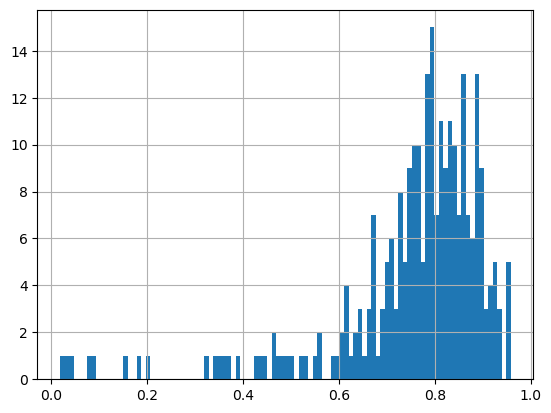

In [20]:
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)
display(score_df.head(3))
score_df["score"].hist(bins=100)


In [21]:

score_df = score_df.sort_values("score").reset_index(drop=True)
score_df.head(20)


,series_id,score,detected_event_num
0,60d31b0bec3b,0.018915,789
1,5aad18e7ce64,0.036322,130
2,e4500e7e19e1,0.045833,84
3,4feda0596965,0.076453,125
4,f56824b503a0,0.084762,110
5,60e51cad2ffb,0.159259,23
6,10469f6765bf,0.179611,341
7,b7fc34995d0f,0.202765,155
8,13b4d6a01d27,0.327007,249
9,05e1944c3818,0.341509,262
